### Your name:

<pre> Michael Ciniello qq217352</pre>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
#reset the graph
def reset_graph(seed=123):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

### TensorFlow

#### Q1. When is a variable initialized? When is it destroyed?

A variable is initialized when you call its initializer, and its detroyed when the session ends. In distributed TensorFlow however, variabeles live in containers on the cluster, so closing a session will not destory the variable... To do this you must clear the variable's container!

#### Q2. What is the difference between a placeholder and a variable?

Variables and placeholders are very differnet:
- A variable is an operation that holds a value. If you run the variable, it returns that value, and before you run it you need to initialize it. You can also change the variables value by using the assignment operation. Variables are stateful, meaning that they keep the same value upon succesive runs of the graph (unless you change it with the assignment operation). Variables are typically used to hold model parameters but also for other purposes (e.g. to count the global training step).
- Placeholders technically do not do very much: they just hold information about the type of shape of the tensor they represent, but they have no value. In fact, if you try to evaluation an operation that depends on a placeholder, you must feed TensorFlow the value of the placeholder (using the feed_dict argument) or else you will get an exception. Placeholders are typically used to feed training or test data to TensorFlow during the execution phase, or to pass a value to an assignment node to change the value of a variable. 

#### Q3. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

- Reverse-mode autodiff needs to traverse the graph only twice in order to copmute the gradients of the cost function with regards to any number of variables. 
- Forward-mode auto-diff would need to run once for each variable (so 10 times if we want the gradients with regards to 10 different variables).
- Symbolic differentiation would build a separate graph to compute the gradients, so it would not traverse the original graph at all (except when building the new gradients graph). Furthermore, a highly optimized symbolic differentiation system could potentially run the new gradients graph only once to compute the gradients of all variables, HOWEVER the new graph may be horribly complex and inefficient compared to the original graph.

#### Q4. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using name scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

#### Import Data

In [3]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise = 0.1, random_state=42)

#### Explore Data

Shape:  (1000, 2)


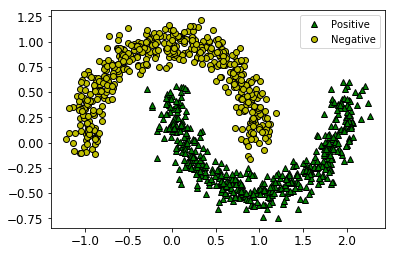

In [4]:
import matplotlib.pyplot as plt
print("Shape: ",X_moons.shape)

plt.plot(X_moons[y_moons == 1,0], X_moons[y_moons == 1, 1], 'g^',markeredgecolor='black', label='Positive')
plt.plot(X_moons[y_moons == 0,0], X_moons[y_moons == 0, 1], 'yo',markeredgecolor='black', label='Negative')
plt.legend()
plt.show()

#### Clean Data

In [5]:
#Add bias feature x0=1 to every instances
import numpy as np
X_moons_with_bias = np.c_[np.ones((m,1)),X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [6]:
#Reshape y_train to make a column vector
print("old shape ",y_moons.shape)
y_moons_column_vector = y_moons.reshape(-1 ,1)
print("new shape ", y_moons_column_vector.shape)

old shape  (1000,)
new shape  (1000, 1)


#### Training/Test Split

In [7]:
#Split data into train and test sets
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 3)
(200, 3)
(800, 1)
(200, 1)


Create function that generates random batches. The function should pick random instances from training set, with replacement. This means that batches may contain duplicate instances, and so a single epoch might not cover all of the training instances (this is bagging I beleive... and it means we will only use about 2/3 of the training instances. In practice this is not an issue, and it simplifies the code.

In [8]:
def random_batch(X_train, y_train,  batch_size):
    rnd_indices = np.random.randint(0,len(X_train),batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

#test the function
X_batch, y_batch = random_batch(X_train, y_train, 5)
print("X: ",X_batch)
print("y: ",y_batch)

X:  [[ 1.         -0.03703635  0.88578278]
 [ 1.          0.87744313  0.08639556]
 [ 1.          1.01181732 -0.45802039]
 [ 1.         -0.38243909  0.95223986]
 [ 1.          0.76996505  0.30647189]]
y:  [[0]
 [0]
 [1]
 [0]
 [0]]


#### Build a Logistic Regression
Logisitic Regression models first compute a weighted sum of the inputs just like a Linear Regression, and then it applied the sigmoid function to the result which gives the estimated probability for the positive class:

$ \hat{p} = h_{\mathbf{\theta}}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x}) $

**Extra info for my referral:**
<font color=blue>Recall **the sigma symbol represents the sigmoid function**, and that $\theta$ refers to the parameter vector, containing a bias term $\theta_0$, with the weights $\theta_1$, $\theta_2$,... $\theta_n$.  The input vector $\mathbf{x}$ contains a constant term $x_0$ = 1, as well as all the input features $x_1$, $x_2$,... $x_n$. 

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single vector. The ith row will contain the transpose ith input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:
$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

The moons dataset has two input features (2-dimensions) as each instance is a point on a single plane.

Try building the sigmoid function from scratch, and using the TF built in function:

In [9]:
#reset graph
reset_graph()

n_inputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs +1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n_inputs + 1,1],-1.0,1.0,seed=42),name='theta')
logits = tf.matmul(X,theta,name='logits')

#compute sigmoid from scratch and using TF
#y_proba_scratch = 1 / (1 + tf.exp(-logits))
y_proba = tf.sigmoid(logits)

Good start, lets test this out to see if its working so far:

In [10]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    #test1 = y_proba_scratch.eval(feed_dict={X:X_train,y:y_train})
    test2 = y_proba.eval(feed_dict={X:X_train,y:y_train})
#print(test1.shape)
#print(test1[:5])
print(test2.shape)
print(test2[:5])

(800, 1)
[[ 0.47370079]
 [ 0.30856234]
 [ 0.33085981]
 [ 0.4359203 ]
 [ 0.61283284]]


#### Implement the Cost Function
Build it from scratch, and try TF's built in functions.

In [11]:
epsilon = 1e-7 # to avoid an overflow when computing the log
#loss function from scratch and using TF
#loss_scratch = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
loss = tf.losses.log_loss(y, y_proba) #uses epsilon = 1e-7 by default

In [12]:
with tf.Session() as sess:
    sess.run(init)
    #test1 = loss_scratch.eval(feed_dict={X:X_train,y:y_train})
    test2 = loss.eval(feed_dict={X:X_train,y:y_train})

#print(test1)
print(test2)

0.932825


#### Train the model using Gradient Descent

NOTE: n_batches * batch_size = 1000 (total number of instances the data is trained on), which is equal to total number of rows in trianing set. However we wont get all 1000 trianing instances, as we are using bagging; we should only actually utilize appoximately 66% of the trianing data. 

For each instance in y_proba_val we get the estimated probability that the instance belongs to the POSITIVE class.

In [13]:
#set learning rate, select optimizer, and set trainin_op
learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        #evaluate loss on test data based on updated theta vals
        loss_val = loss.eval(feed_dict={X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch: ", epoch, "\tLoss:", loss_val)
    y_prob_val = y_proba.eval(feed_dict={X:X_test,y:y_test})

print(y_prob_val[:5])
y_pred = y_prob_val>=0.5
print(y_pred[:5])

Epoch:  0 	Loss: 0.869047
Epoch:  100 	Loss: 0.34044
Epoch:  200 	Loss: 0.306131
Epoch:  300 	Loss: 0.2919
Epoch:  400 	Loss: 0.284593
Epoch:  500 	Loss: 0.280346
Epoch:  600 	Loss: 0.278374
Epoch:  700 	Loss: 0.276034
Epoch:  800 	Loss: 0.275797
Epoch:  900 	Loss: 0.274512
[[ 0.54694593]
 [ 0.70552075]
 [ 0.51690352]
 [ 0.99117029]
 [ 0.50612777]]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]


### Compute Model Accuracy

Compute precision and recall

Precision:  0.862745098039
Recall:  0.888888888889


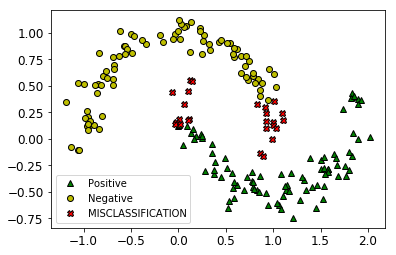

In [14]:
from sklearn.metrics import precision_score, recall_score
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred))

accurate_preds = []
for i,n in enumerate(y_test.reshape(-1)):
    if n == y_pred.reshape(-1)[i]:
        accurate_preds.append(True)
    else:
        accurate_preds.append(False)

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
#correct positive
plt.plot(X_test[y_pred_idx*accurate_preds, 1], X_test[y_pred_idx*accurate_preds, 2], 'g^',markeredgecolor='black', label="Positive")
#correct negative
plt.plot(X_test[~y_pred_idx*accurate_preds, 1], X_test[~y_pred_idx*accurate_preds, 2], 'yo',markeredgecolor='black', label="Negative")
#incorrect classification
plt.plot(X_test[~np.array(accurate_preds),1],X_test[~np.array(accurate_preds),2],'rX',markeredgecolor='black', label="MISCLASSIFICATION")
plt.legend()
plt.show()

### Try a new model!

The logistic model doesnt work very well on this data because it is a linear model, and this data is clearly non-linear. We mus try some alternatives, like polynomial regression for instance. 

Sklearn's PolynomialFeatures class generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.  For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [15]:
# reload data
from sklearn.datasets import make_moons
m = 1000
X, y = make_moons(m, noise = 0.1, random_state=42)

# add polynomial features and resplit the data
from sklearn.preprocessing import PolynomialFeatures
poly_feats = PolynomialFeatures(degree=4, include_bias=True)

X_poly = poly_feats.fit_transform(X)
print(X_poly.shape)

#Split data into train and test sets
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train_poly = X_poly[:-test_size]
X_test_poly = X_poly[-test_size:]
y_train = y[:-test_size].reshape(-1,1)
y_test = y[-test_size:].reshape(-1,1)

print(X_train_poly.shape)
print(X_test_poly.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 15)
(800, 15)
(200, 15)
(800, 1)
(200, 1)


In [16]:
#reset the graph
reset_graph()

#### Create Logisitic Regression Function

In [17]:
#create a logis
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [18]:
# create funciton to get name of log directory
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "MC_tf_logs"
    #if prefix is entered, add "-" to the end
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

# test log_dir function
log_dir('home')

'MC_tf_logs/home-run-20171205003813/'

### Create a graph 

- using the logistic_regression() function, and create the FileWriter to save the summaries to the log directory for TensorBoard

Run model and create checkpoints are each epoch!

Quick note on the open('file', 'mode') function:
- The first argument is a string containing the filename. The second argument is another string containing a few characters describing the way in which the file will be used. mode can be 'r' when the file will only be read, 'w' for only writing (an existing file with the same name will be erased), and 'a' opens the file for appending; any data written to the file is automatically added to the end. 'r+' opens the file for both reading and writing. The mode argument is optional; 'r' will be assumed if it’s omitted.
- On Windows, 'b' appended to the mode opens the file in binary mode, so there are also modes like 'rb', 'wb', and 'r+b'. Python on Windows makes a distinction between text and binary files; the end-of-line characters in text files are automatically altered slightly when data is read or written. This behind-the-scenes modification to file data is fine for ASCII text files, but it’ll corrupt binary data like that in JPEG or EXE files. Be very careful to use binary mode when reading and writing such files. On Unix, it doesn’t hurt to append a 'b' to the mode, so you can use it platform-independently for all binary files.



### Run the Model

In [19]:
import os
#reset the graph
reset_graph()

#set graph
n_inputs = X_train_poly.shape[1]
logdir = log_dir('hmwk9_models')
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X,y)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

#set params for model run
n_epochs = 5000
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

checkpoint_path = '/temp/model_log.ckpt'
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = './model_log'

with tf.Session() as sess:
    training_dict = {X:X_train_poly, y:y_train}
    test_dict = {X:X_test_poly, y:y_test}
    #IF CHECKPOINT PATH EXISTS RESTORE THE MODEL AND LOAD EPOCH NUMBER
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("Training interupted. Continuing from epoch:", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
            sess.run(training_op, feed_dict=training_dict)
        loss_val, summary_str = sess.run([loss, loss_summary],feed_dict=training_dict)
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch: ", epoch, "\tLoss: ", loss_val)
            saver.save(sess,checkpoint_path)
            with open(checkpoint_epoch_path,'wb') as f:
                f.write(b"%d" % (epoch+1))
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict=test_dict)
    #remove checkpoint save as the the full training is complete!
    os.remove(checkpoint_epoch_path)

file_writer.close()

Epoch:  0 	Loss:  0.665014
Epoch:  500 	Loss:  0.13326
Epoch:  1000 	Loss:  0.0851441
Epoch:  1500 	Loss:  0.0639598
Epoch:  2000 	Loss:  0.0519585
Epoch:  2500 	Loss:  0.0441603
Epoch:  3000 	Loss:  0.0386428
Epoch:  3500 	Loss:  0.0345094
Epoch:  4000 	Loss:  0.0312835
Epoch:  4500 	Loss:  0.0286872


Precision:  0.980198019802
Recall:  1.0


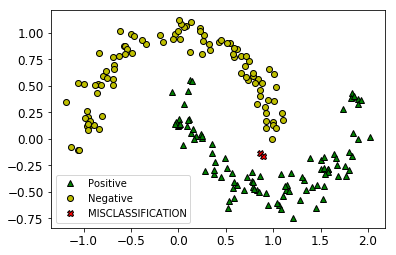

In [20]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred))

accurate_preds = []
for i,n in enumerate(y_test.reshape(-1)):
    if n == y_pred.reshape(-1)[i]:
        accurate_preds.append(True)
    else:
        accurate_preds.append(False)

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
#correct positive
plt.plot(X_test[y_pred_idx*accurate_preds, 1], X_test[y_pred_idx*accurate_preds, 2], 'g^',markeredgecolor='black', label="Positive")
#correct negative
plt.plot(X_test[~y_pred_idx*accurate_preds, 1], X_test[~y_pred_idx*accurate_preds, 2], 'yo',markeredgecolor='black', label="Negative")
#incorrect classification
plt.plot(X_test[~np.array(accurate_preds),1],X_test[~np.array(accurate_preds),2],'rX',markeredgecolor='black', label="MISCLASSIFICATION")
plt.legend()
plt.show()

This looks much better! And the loss value is below 2%, which seems pretty solid. Lets have a look on tensorboard.
![](Picture1.png)

Now lets try to optimize the model's hyperparameters (learning rate and batch size) using randomized search.

Quick not on the reciprocal function: The reciprocal() function from SciPy's stats module returns a random distribution that is commonly used when you have no idea of the optimal scale of a hyperparameter. See the exercise solutions for chapter 2 for more details.

Full disclosure, I rebuilt this code using the example in the textbook.

In [21]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = X_train_poly.shape[1]
    logdir = log_dir("hmwk9_models")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_poly, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_poly, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: MC_tf_logs/hmwk9_models-run-20171205003932/
  batch size: 54
  learning_rate: 0.00443037524522
  training: .....................
  precision: 0.980198019802
  recall: 1.0
Iteration 1
  logdir: MC_tf_logs/hmwk9_models-run-20171205004130/
  batch size: 16
  learning_rate: 0.00178264971514
  training: .....................
  precision: 0.980198019802
  recall: 1.0
Iteration 2
  logdir: MC_tf_logs/hmwk9_models-run-20171205004732/
  batch size: 19
  learning_rate: 0.00203228544324
  training: .....................
  precision: 0.980198019802
  recall: 1.0
Iteration 3
  logdir: MC_tf_logs/hmwk9_models-run-20171205005243/
  batch size: 96
  learning_rate: 0.00449152382514
  training: .....................
  precision: 0.979797979798
  recall: 0.979797979798
Iteration 4
  logdir: MC_tf_logs/hmwk9_models-run-20171205005400/
  batch size: 6
  learning_rate: 0.0796323472178
  training: .....................
  precision: 1.0
  recall: 1.0
Iteration 5
  logdir: MC_tf_logs/hmwk

![](Picture2.png)

### Submit your notebook

Submit your solution here
https://goo.gl/forms/VKD7Zwu54oHjutDc2
Make sure you rename your notebook to    
W3_UTORid.ipynb    
Example W3_adfasd01.ipynb
